# A very simple deep learning tutorial

## A super brief introduction to CNNs

These Stanford course notes http://cs231n.github.io/convolutional-networks/ are amazing, it doesn't take long to go through them and get a pretty good understanding of CNNs (and other neural nets too). I'll add a couple of images with descriptions from those notes to give you an idea of CNNs. Another really well-written resource is http://colah.github.io/posts/2014-07-Conv-Nets-Modular/.

This is the basic structure of any neural network, which were invented to attempt to emulate the connections found in the brain. Essentially it learns a non-linear transformation which converts input to output. Like any machine learning algorithm, you train it on some training data with known output. The hidden layers are made up of "neurons", which connect to every feature of the input, performing said non-linear transforms. Each neuron has a weight and these are learned from training data. 

<img src="neural_net2.jpeg">

<b>What makes convolutional neural networks different?</b>

It's usually quite rare to get much benefit from making neural networks more than one or two layers deep. CNNs are different because they can be dozens or even hundreds of layers deep.

CNNs are truly designed to work with images, it's built into their architecture (although it is possible to use them successfully on other types of features). Neurons (which actually tend to be called nodes or filters in CNN literature) now have volume instead of just being points. This is because they are designed to look at small pieces of the input image (this division of labour makes it possible to go so deep) within their little volume, called a "receptive field".

<img src="neural_net2a.jpeg">

The "convolution" part of convolutional neural networks refers to a particular type of layer, a convolutional layer, which is made up of filters that, when training, <i>slide</i> around the image, filtering bits of it (which is a convolution in effect) to see what filters get activated by what parts of the image.

The last thing I'll talk about is the fact that CNNs are not purely made of convolutional layers. There are several types, the most common of which are: fully connected or dense layers ("standard" neural network layers), convolutional layers, activation layers (which does the "what filters are activated by what" bit) such as "ReLu" layer, pooling layers (pool filters from previous layers and downsample) and dropout layers (which drop some of the weights to prevent overfitting). The best thing is to read the notes on these things. The most difficult part of deep learning is figuring out what combinations of layers to use, as there aren't any hard and fast rules. Here's an example network architecture:

<img src="convnet.jpeg">

## On to the tutorial
In this simple tutorial, we have a very clean sample of galaxies from the <a href=https://arxiv.org/abs/2102.08414>Galaxy Zoo DECaLS</a> dataset for which all volunteers agreed on the morphology of the galaxy (spiral vs. elliptical). We will use an extremely simple neural network to automatically classify this sample. Note that in order to make sure this notebook runs easily on even the most lightweight laptop, we will not use a complex network nor a very long training time. So this is by no means the best performance possible but should still give you a good idea of the deep learning workflow.

This tutorial is based heavily on the <a href=https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html>PyTorch documentation</a> (which is very helpful) and adapted to run on the galaxy sample.

### Why PyTorch?
There are several alternatives when running deep learning models, the most notable being <a href=https://www.tensorflow.org/>TensorFlow</a>, developed by Google, and <a href=https://pytorch.org/>PyTorch</a>, developed by Meta AI and now under the Linux Foundation. Each has their strengths and weaknesses and both will get the job done well. Having used both, I found that while PyTorch requires some initial annoying boilerplate code (such as writing a class to read in the dataset), it's much more "pythonic" and easier to adapt to whatever you need while TensorFlow can be a bit more opaque. So we will use PyTorch here but you should explore which is the best option for your application.

### Installations

You should already have `matplotlib`, `numpy` and `sklearn` installed. I personally like to use the `widget` backend for plots which requires you to install the library `ipympl`. You will also need to install pytorch. If you're using a CPU and pip use this command:

`pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu`

Please look up alternative instructions on the pytorch webpage if you're using conda or want to use a GPU (which is much easier with pytorch than with tensorflow in my experience).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from PIL import Image
import time
import os
import subprocess

%matplotlib widget

### Transforms
Generally, all networks will require the data to be transformed appropriately. If you're using a pretrained network for something, you'll generally have to make sure the transforms match what was done to the training data. If you're training from scratch, it may take some experimentation to find the set of transforms that produces the best performance. Remember, CNNs are ultimately giant filter banks so they can be quite sensitive to data preprocessing. 

PyTorch has a suite of transforms available and you can chain them together using `Compose`. For this example, all we will do is convert the image to a "tensor" for torch to work with, but I've left commented out a set of transforms that's standard to use with Resnet.

In [2]:
# These are the transforms commonly used with the Resnet architecture

# preprocess = transforms.Compose([
#         # transforms.Resize(256),
#         # transforms.CenterCrop(224), # You would normally do this but I've already resized the images
#         transforms.ToTensor(),
#         transforms.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225]
#     )])

preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])

### Reading in the data
PyTorch is quite unique in how it works with data in that it's entirely up to you how you want your data to be read in. In order to work with the batching process (neural nets train in batches which is more memory efficient), you must define a Dataset class that implements a `__len__` and `__getitem__` method but other than that, there aren't any restrictions. Here I choose to work with dictionaries to store information about each object but many people return lists instead.

In [3]:
class ThumbnailsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Class to read in data from png files. The data should be stored in separate folders where each folder is a different class.
        
        params
        ------
        root_dir : string
            The directory where the data are
        transform : torchvision.transforms.Transform object, optional
            Any transforms to be applied to the data (at a minimum, toTensor should be applied).
        """
        self.transform = transform
        classes = os.listdir(root_dir)
        self.file_paths = [] # Stores where the data are
        self.targets = [] # Stores the class for each object
        class_index = 0
        for c in classes:
            files = os.listdir(os.path.join(root_dir, c))
            self.file_paths += [os.path.join(root_dir, c, f) for f in files if 'png' in f]
            self.targets += [class_index]*len(files)
            class_index += 1

    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.file_paths)

    def __getitem__(self, idx):
        """
        Retrieves an item in the dataset indexed by an integer, idx.
        """

        # Assumes the name of the object should be the filename. You could (for example) read in some other metadata here
        im_name = self.file_paths[idx].split(os.path.sep)[-1].split('.')[0]
        # Uses PIL to open the image
        image = Image.open(self.file_paths[idx]).convert('RGB') 
        # Stores these in a little dictionary
        sample = {'image': image, 'name':im_name, 'class': self.targets[idx]}
        
        # Applies the transform if requested
        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample

Extract the data if it hasn't been already

In [4]:
data_root = os.path.join('data','galaxy_zoo','')

if not os.path.exists(data_root):
    subprocess.call(['unzip', 'data/galaxy_zoo.zip', '-d', 'data']) # This probably only works on linux or mac

We will read in the training data and the test data separately

In [5]:
training_dataset = ThumbnailsDataset(os.path.join(data_root, 'training'), transform=preprocess)
test_dataset = ThumbnailsDataset(os.path.join(data_root, 'test'), transform=preprocess)

### Plot a few examples

In [6]:
def plot_galaxy(dataset, idx):
    """
    Convenience function to make a nice image of a particular galaxy
    """
    # Retrieve the image
    im = dataset[idx]['image']
    # For whatever reason, torch and matplotlib expect different orders of the channels so we need to permute them
    im = im.permute(1, 2, 0)
    # Show the image
    plt.imshow(im)
    
    # Get the class and put it in a title
    target = dataset[idx]['class']
    if target == 0:
        title = 'elliptical'
    else:
        title = 'spiral'
    plt.xticks([])
    plt.yticks([])
    plt.title(title)

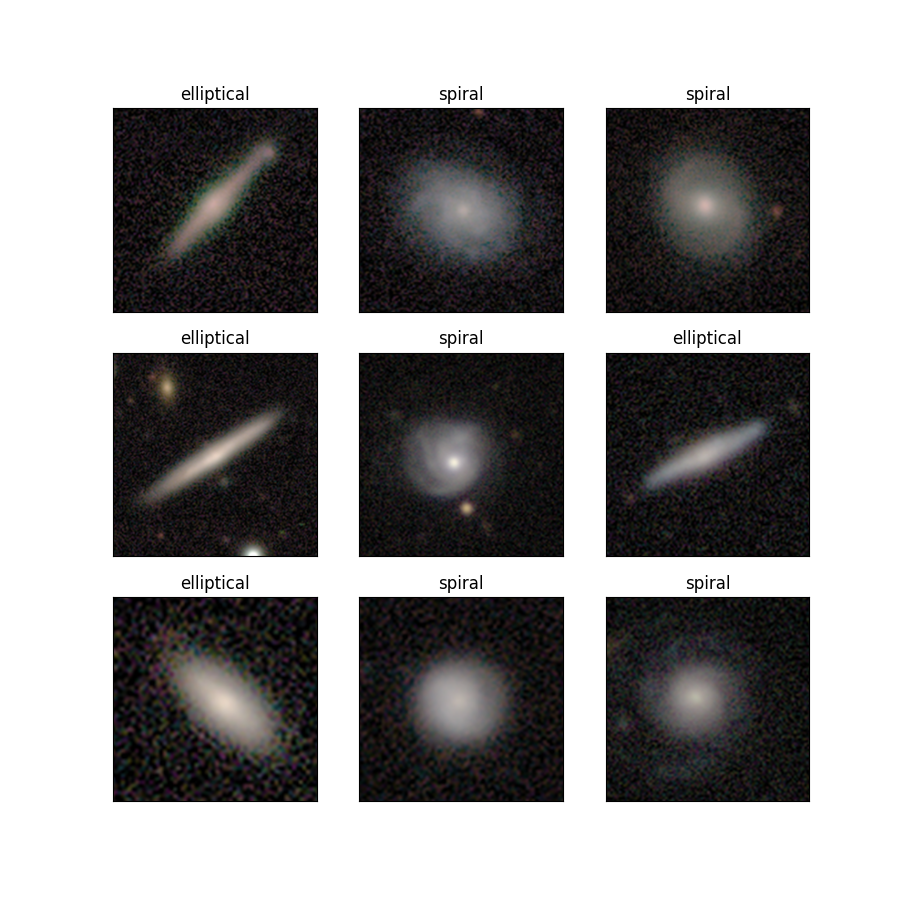

In [7]:
# Pick some random examples
inds = np.random.choice(np.arange(len(training_dataset)), 9, replace=False)

plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    idx = inds[i]
    plot_galaxy(training_dataset, idx)

### Build the model

If you want to build your own models out of individual layers, this is pretty easy to do with PyTorch. However, for simplicity we will just use a very common architecture called Resnet (and use a very small version). It's often much easier to use network architectures that have been developed and used by others than to try and mess around with building your own. Although it can be worth exploring because sometimes in astronomy, we don't need the complexity of ImageNet trained models. Simply printing out the model shows you exactly what layers are used.

In [8]:
resnet = models.resnet18()
# print(resnet)

### Set up the training
We have to set two parameters, the learning rate and batch size. For batch size you usually want more or less as large a batch as your memory can handle. The learning rate is more subtle and is a tuning parameter for the optimiser (which is another choice you have to make). These things can impact performance so are worth looking at if you're having problems for a different dataset, but we are using fairly sensible defaults here. We're using a standard cross entropy loss as a metric and another standardly used optimiser.

We use a DataLoader from torch to just help split the dataset up into batches automatically and hopefully intelligently. This becomes really important when working on a GPU.

In [9]:
learning_rate = 1e-3
batch_size = 64

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(resnet.parameters(), lr=learning_rate)

training_dataloader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Train the network
Rather than using a preset "fit" function like python uses, you need to be a little more explicit with torch. This is the price of flexibility that lets you define your dataset and models how you like. We write two little functions to iterate through the training set and run the optimizer.

In [10]:
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Function to iterate through the training set and train the network.
    """
    size = len(dataloader.dataset)
    for batch, dat in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(dat['image'])
        loss = loss_fn(pred, dat['class'])

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(dat['image'])
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    """
    Function to iterate through the test data and evaluate the algorithm.
    """
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for dat in dataloader:
            pred = model(dat['image'])
            test_loss += loss_fn(pred, dat['class']).item()
            correct += (pred.argmax(1) == dat['class']).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [11]:
# Now we actually iterate through each epoch, checking performance as we go.
t1 = time.perf_counter()
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(training_dataloader, resnet, loss_fn, optimizer)
    test_loop(test_dataloader, resnet, loss_fn)
print("Done!")
print(f"Time taken {time.perf_counter()-t1:.2f}s")

Epoch 1
-------------------------------
loss: 6.781271  [    0/  800]
Test Error: 
 Accuracy: 50.0%, Avg loss: 4.649301 

Epoch 2
-------------------------------
loss: 4.733349  [    0/  800]
Test Error: 
 Accuracy: 50.0%, Avg loss: 2.684891 

Epoch 3
-------------------------------
loss: 2.788679  [    0/  800]
Test Error: 
 Accuracy: 51.5%, Avg loss: 1.532434 

Epoch 4
-------------------------------
loss: 1.486775  [    0/  800]
Test Error: 
 Accuracy: 66.0%, Avg loss: 1.049332 

Epoch 5
-------------------------------
loss: 1.025280  [    0/  800]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.865956 

Epoch 6
-------------------------------
loss: 0.844250  [    0/  800]
Test Error: 
 Accuracy: 82.0%, Avg loss: 0.767214 

Epoch 7
-------------------------------
loss: 0.752229  [    0/  800]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.705565 

Epoch 8
-------------------------------
loss: 0.661463  [    0/  800]
Test Error: 
 Accuracy: 83.5%, Avg loss: 0.663933 

Epoch 9
----------------

### How well did we do?

In [12]:
# Collect a set of predictions for the test data
predictions = []
targets = []
with torch.no_grad():
    for dat in test_dataloader:
        pred = resnet(dat['image'])
        predictions += list(pred.argmax(1))
        targets += list(dat['class'])
targets = np.array(targets)
predictions = np.array(predictions)

#### Correct examples
Examples where the network predicted the class correctly.

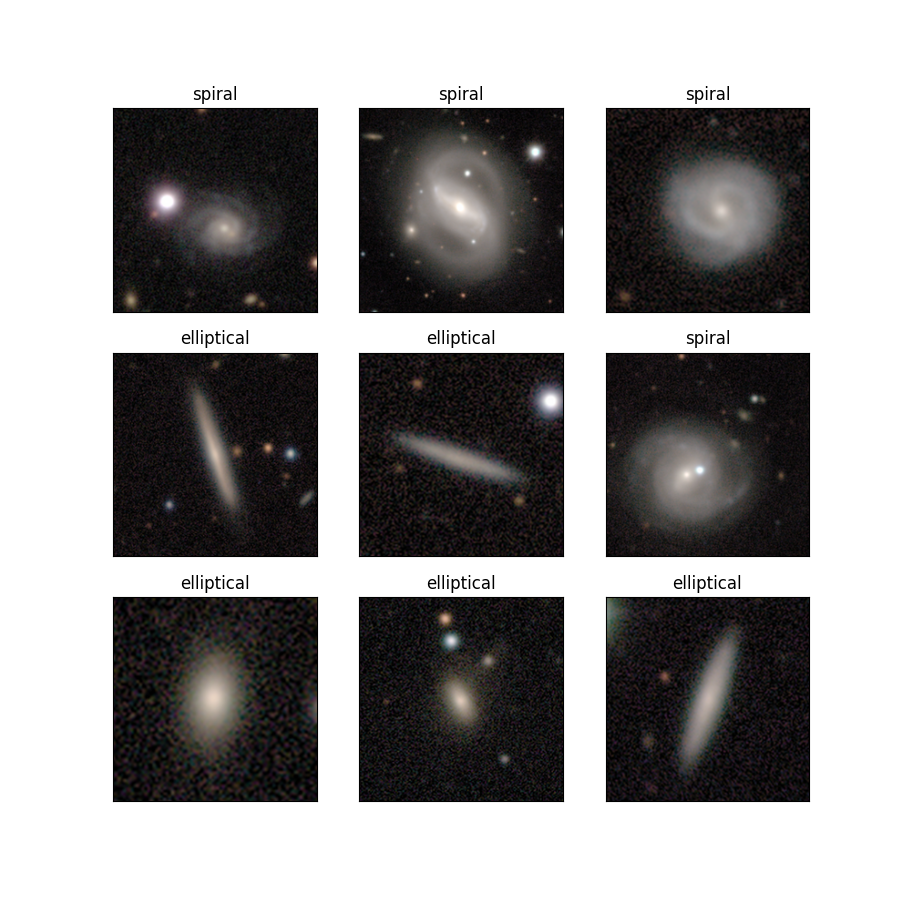

In [13]:
correct_inds = np.random.choice(np.arange(len(targets))[targets==predictions], 9, replace=False)
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    idx = correct_inds[i]
    plot_galaxy(test_dataset, idx)

#### Incorrect examples
Examples where the network failed (the true class is indicated in the title).

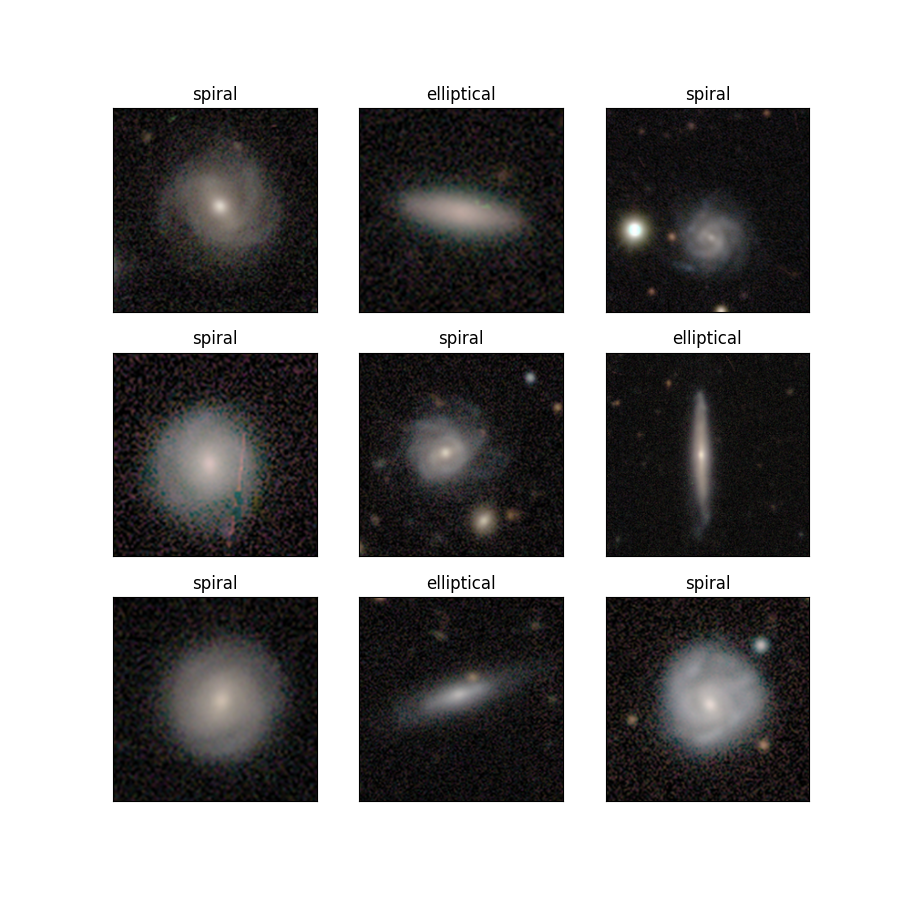

In [14]:
wrong_inds = np.random.choice(np.arange(len(targets))[targets!=predictions], 9, replace=False)
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3,3,i+1)
    idx = wrong_inds[i]
    plot_galaxy(test_dataset, idx)

#### Confusion matrix plot

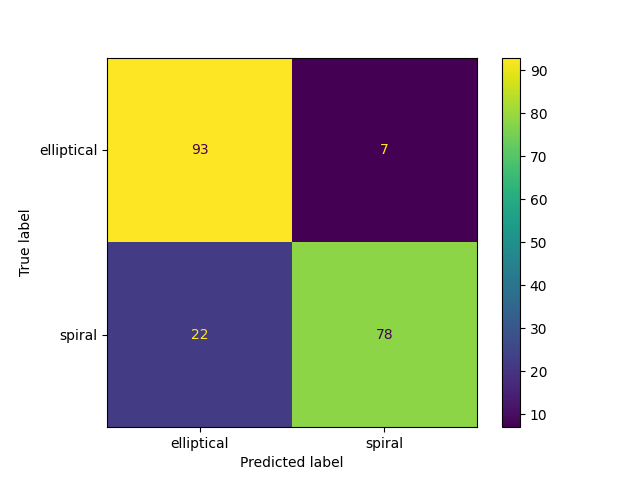

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(targets, predictions)
disp = ConfusionMatrixDisplay(cm, display_labels=['elliptical', 'spiral'])
disp.plot()

And that's it! Hopefully this is enough to get you started with your own projects